In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

plt.style.use('ggplot')
pd.set_option('display.max_columns', False)
seed= 92

# Load Data

In [3]:
train= pd.read_csv('/Users/harshitagarwal/Desktop/Kaggle Competitions/Titanic - ML from Disaster/titanic/train.csv')
test= pd.read_csv('/Users/harshitagarwal/Desktop/Kaggle Competitions/Titanic - ML from Disaster/titanic/test.csv')

# EDA
## -> Check For Duplicates
## -> Check Shape of the Data
## -> Check initial Trends or Patterns

In [4]:
#Combining train and test datasetss
all_data = pd.concat([train, test], axis=0).reset_index(drop=True) #resets index to a new version and drops the old one

#Duplicates and shapes
print(F"Number of duplicate rows: {len(all_data.drop('Survived', axis=1))-len(all_data.drop('Survived', axis=1).drop_duplicates())}") #total_rows - unique_rows = number of duplicate rows removing 'Survived' column (target)
print(f"Shape of train:    {train.shape}")
print(f"Shape of test:     {test.shape}")
print(f"Shape of all_data: {all_data.shape}")

Number of duplicate rows: 0
Shape of train:    (891, 12)
Shape of test:     (418, 11)
Shape of all_data: (1309, 12)


In [5]:
print('#TRAIN INFO:')
print(train.info(),'\n')
print('#TEST INFO:')
print(test.info())

#TRAIN INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 

#TEST INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 n

# Exploring Columns

In [ ]:
#PassengerId

print(F"Number of duplicates in PassengerId column = {len(all_data)-len(pd.unique(all_data['PassengerId']))}")

Number of duplicates in PassengerId column = 0


In [ ]:
#Survived

print("Value count")
print(train['Survived'].value_counts()) #returns unique values for 'Survived' column
print("\nRatio")
print(train['Survived'].value_counts(normalize= True)) # returns proportions instead of count

Value count
Survived
0    549
1    342
Name: count, dtype: int64

Ratio
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


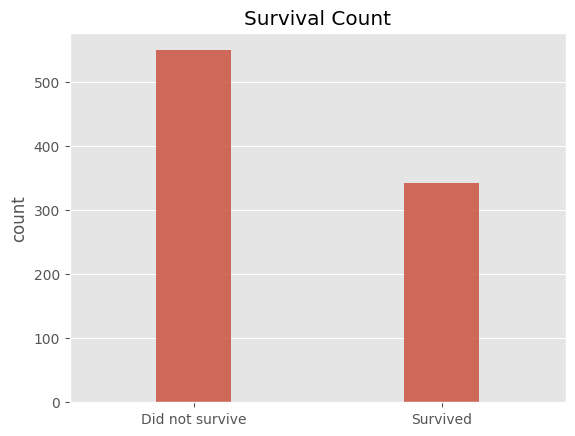

In [ ]:
sns.countplot(data=train, x='Survived', width= 0.3, alpha= 0.9) #bar chart, x-axis = column
plt.xticks(ticks=[0, 1], labels=['Did not survive', 'Survived'])
plt.title("Survival Count")
plt.xlabel("")
plt.show()

In [13]:
#Pclass

pclass_pivot = train.pivot_table(index='Pclass', columns='Survived', values='PassengerId', aggfunc='count')
pclass_pivot.columns = ['No', 'Yes']
pclass_pivot['Total'] = pclass_pivot['Yes'] + pclass_pivot['No']
pclass_pivot['Survival %'] = round(pclass_pivot['Yes'] / (pclass_pivot['Yes'] + pclass_pivot['No']) * 100,1).astype(str) + '%'
pclass_pivot

,No,Yes,Total,Survival %
Pclass,,,,
1,80,136,216,63.0%
2,97,87,184,47.3%
3,372,119,491,24.2%


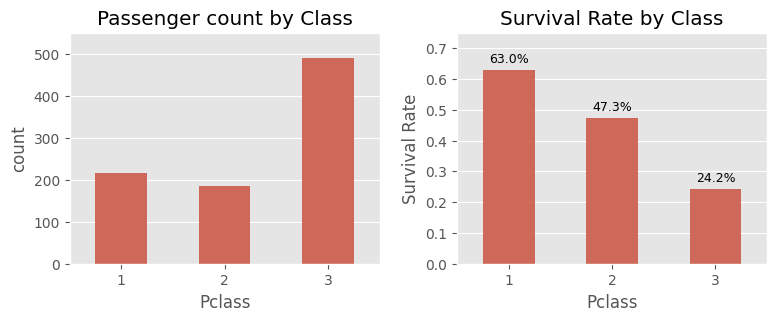

In [14]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Pclass", data=train, width= 0.5, alpha= 0.9, ax=ax1)
ax1.set_title("Passenger count by Class")
ax1.set_ylim([0, 550])


ax2= plt.subplot(1,2,2)
pclass_survival_rate = train.groupby('Pclass')['Survived'].mean().reset_index()
sns.barplot(x='Pclass', y='Survived', data=pclass_survival_rate,  alpha= 0.9, width= 0.5, ax= ax2)
ax2.set_title('Survival Rate by Class')
ax2.set_xlabel('Pclass')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.75])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

In [15]:
#Name

print(F"Number of duplicates in Name column = {len(all_data)-len(pd.unique(all_data['Name']))}")

Number of duplicates in Name column = 2


In [16]:
all_data[all_data.duplicated(subset='Name', keep=False)].sort_values('Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q
897,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [17]:
#Sex

sex_pivot = train.pivot_table(index='Sex', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
sex_pivot.columns = ['No', 'Yes']
sex_pivot['Total'] = sex_pivot.sum(axis=1)
sex_pivot['Survival %'] = round(sex_pivot['Yes'] / sex_pivot['Total']  * 100,1).astype(str) + '%'
sex_pivot

,No,Yes,Total,Survival %
Sex,,,,
female,81,233,314,74.2%
male,468,109,577,18.9%


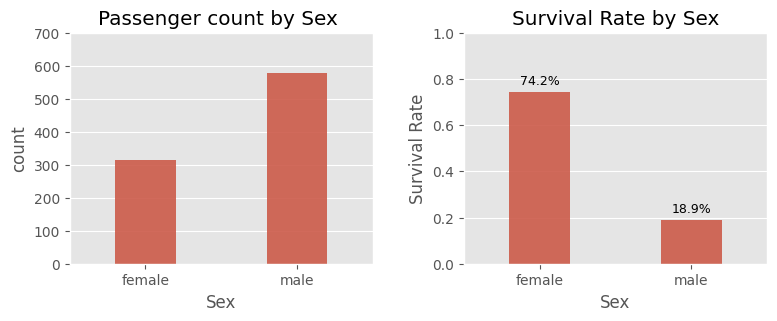

In [18]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Sex", data=train, width= 0.4, alpha= 0.9, order=['female', 'male'], ax=ax1)
ax1.set_title("Passenger count by Sex ")
ax1.set_ylim([0, 700])


ax2= plt.subplot(1,2,2)
sex_survival_rate = train.groupby('Sex')['Survived'].mean().reset_index()
sns.barplot(x='Sex', y='Survived', data=sex_survival_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Survival Rate by Sex')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 1])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.3)
plt.show()

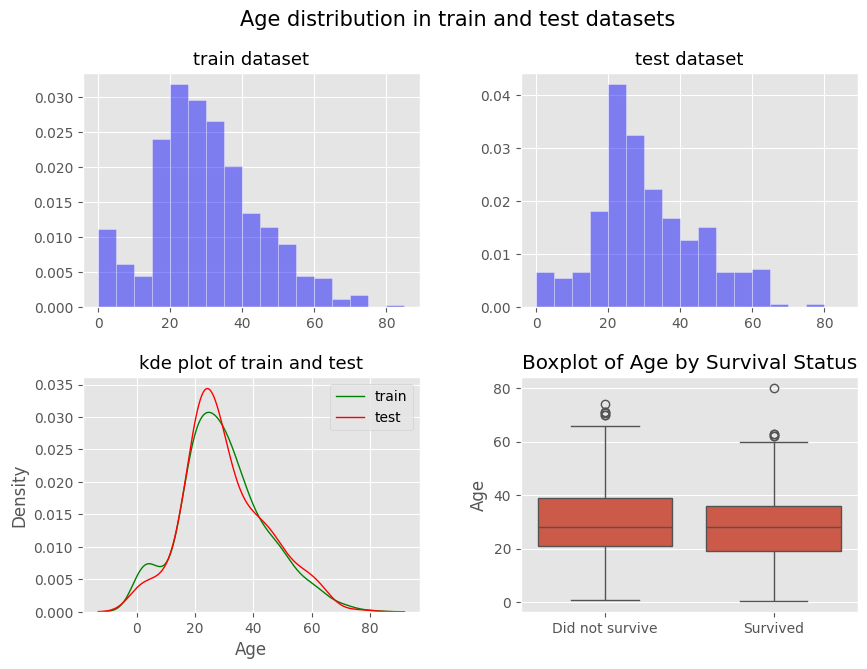

In [19]:
#Age 

fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(2, 2, 1)
count, bin_edges = np.histogram(train['Age'].dropna(), bins=range(0, 90, 5))
ax1.hist(train['Age'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax1.set_title('train dataset', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
count, bin_edges = np.histogram(test['Age'].dropna(), bins=range(0, 90, 5))
ax2.hist(test['Age'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax2.set_title('test dataset', fontsize=13)

ax3 = plt.subplot(2, 2, 3)
sns.kdeplot(data=train, x='Age', color='green', label='train', linewidth= 1, ax=ax3)
sns.kdeplot(data=test, x='Age', color='red', label='test', linewidth= 1, ax=ax3)
plt.legend()
ax3.set_title('kde plot of train and test', fontsize=13)

ax4 = plt.subplot(2, 2, 4)
sns.boxplot(data=train.dropna(subset=['Age']), y="Age", x="Survived", ax=ax4)
ax4.set_xticks([0, 1], ['Did not survive', 'Survived'])
ax4.set_title("Boxplot of Age by Survival Status")
ax4.set_xlabel("")

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.suptitle('Age distribution in train and test datasets', y=0.97, fontsize=15)

plt.show()

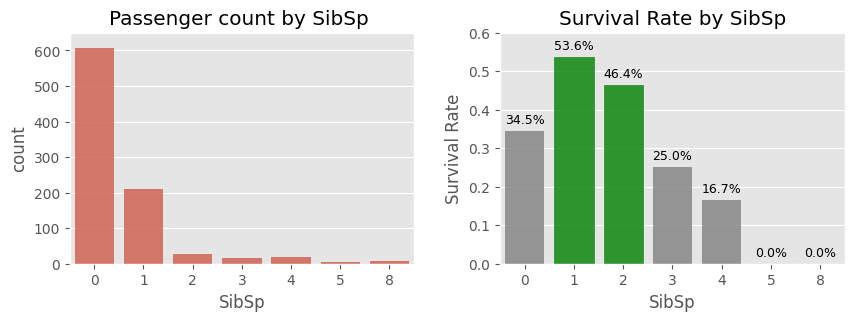

In [20]:
#SibSp

fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="SibSp", data=train, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by SibSp ")
ax1.set_ylim([0, 650])

ax2= plt.subplot(1,2,2)
sibsp_survival_rate = train.groupby('SibSp')['Survived'].mean().reset_index()
sns.barplot(x='SibSp', y='Survived', data=sibsp_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,3):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by SibSp')
ax2.set_xlabel('SibSp')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.6])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

In [21]:
SibSp_pivot= train.pivot_table(index= 'SibSp', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
SibSp_pivot.columns= ['No','Yes']
SibSp_pivot['Total'] = SibSp_pivot.sum(axis=1)
SibSp_pivot['Survival %']= round(SibSp_pivot['Yes']/SibSp_pivot['Total']*100,1).astype(str) + '%'
SibSp_pivot

,No,Yes,Total,Survival %
SibSp,,,,
0,398,210,608,34.5%
1,97,112,209,53.6%
2,15,13,28,46.4%
3,12,4,16,25.0%
4,15,3,18,16.7%
5,5,0,5,0.0%
8,7,0,7,0.0%


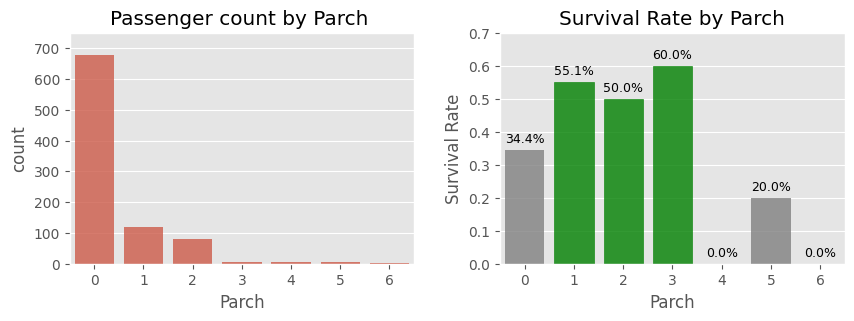

In [22]:
#Parch

fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Parch", data=train, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by Parch ")
ax1.set_ylim([0, 750])

ax2= plt.subplot(1,2,2)
Parch_survival_rate = train.groupby('Parch')['Survived'].mean().reset_index().sort_values(by='Survived', ascending=False)
sns.barplot(x='Parch', y='Survived', data=Parch_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,4):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by Parch')
ax2.set_xlabel('Parch')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.7])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

In [23]:
parch_pivot= train.pivot_table(index= 'Parch', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
parch_pivot.columns= ['No','Yes']
parch_pivot['Total'] = parch_pivot.sum(axis=1)
parch_pivot['Survival %']= round(parch_pivot['Yes']/parch_pivot['Total']*100,1).astype(str) +'%'
parch_pivot

,No,Yes,Total,Survival %
Parch,,,,
0,445,233,678,34.4%
1,53,65,118,55.1%
2,40,40,80,50.0%
3,2,3,5,60.0%
4,4,0,4,0.0%
5,4,1,5,20.0%
6,1,0,1,0.0%


In [24]:
#Ticket 

train['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [25]:
#Fare

print(F"Number of unique Fare values= {len(pd.unique(train['Fare']))}")

Number of unique Fare values= 248


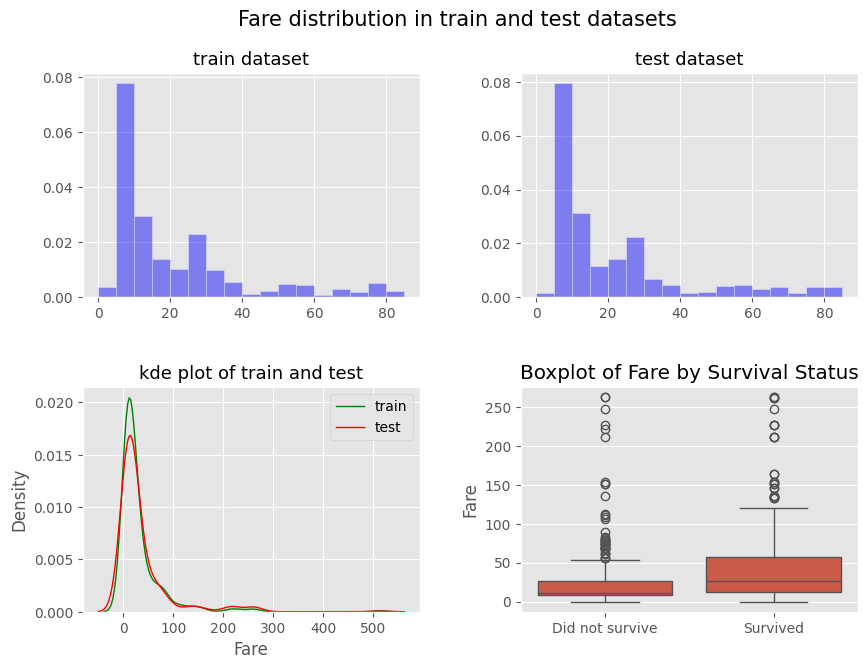

In [26]:
fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(2, 2, 1)
count, bin_edges = np.histogram(train['Fare'], bins=range(0, 90, 5))
ax1.hist(train['Fare'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax1.set_title('train dataset', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
count, bin_edges = np.histogram(test['Fare'], bins=range(0, 90, 5))
ax2.hist(test['Fare'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax2.set_title('test dataset', fontsize=13)

ax3 = plt.subplot(2, 2, 3)
sns.kdeplot(data=train, x='Fare', color='green', label='train', linewidth= 1, ax=ax3)
sns.kdeplot(data=test, x='Fare', color='red', label='test', linewidth= 1, ax=ax3)
ax3.legend()
ax3.set_title('kde plot of train and test', fontsize=13)

ax4 = plt.subplot(2, 2, 4)
sns.boxplot(data=train[train['Fare']<500], y="Fare", x="Survived", ax=ax4)
ax4.set_xticks([0, 1], ['Did not survive', 'Survived'])
ax4.set_title("Boxplot of Fare by Survival Status")
ax4.set_xlabel("")

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle('Fare distribution in train and test datasets', y=0.97, fontsize=15)
plt.show()

In [27]:
#Cabin

train['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

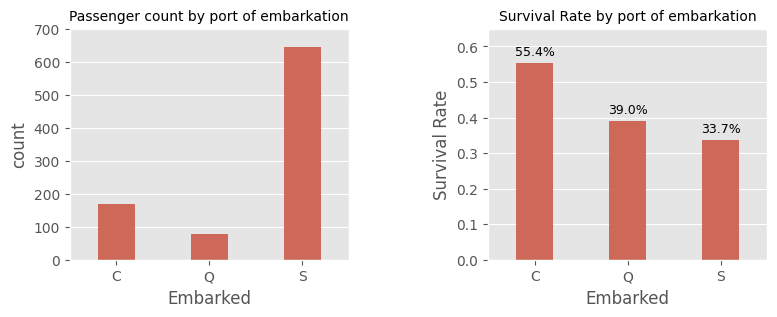

In [28]:
#Embarked

fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Embarked", data=train, width= 0.4, alpha= 0.9, order=['C', 'Q', 'S'], ax=ax1)
ax1.set_title("Passenger count by port of embarkation", fontsize=10)
ax1.set_ylim([0, 700])


ax2= plt.subplot(1,2,2)
Embarked_survival_rate = train.groupby('Embarked')['Survived'].mean().reset_index()
sns.barplot(x='Embarked', y='Survived', data=Embarked_survival_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Survival Rate by port of embarkation', fontsize=10)
ax2.set_xlabel('Embarked')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.65])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [29]:
embarked_pivot = train.pivot_table(index='Embarked', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
embarked_pivot.columns = ['No', 'Yes']
embarked_pivot['Total'] = embarked_pivot.sum(axis=1)
embarked_pivot['Survival %'] = round(embarked_pivot['Yes'] / embarked_pivot['Total']  * 100,1).astype(str) + '%'
embarked_pivot

,No,Yes,Total,Survival %
Embarked,,,,
C,75,93,168,55.4%
Q,47,30,77,39.0%
S,427,217,644,33.7%


# Correlation

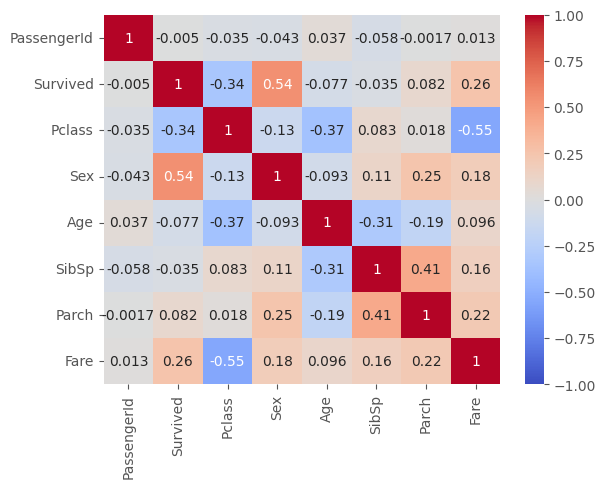

In [33]:
train['Sex'] = train['Sex'].map({'male':0, 'female':1})
corr = train.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


# Data Wrangling

In [34]:
#Imputing Missing Values

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

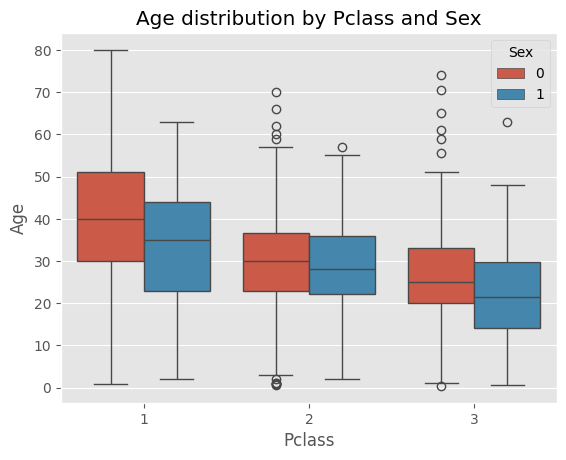

In [35]:
# Missing values in the Age Column

sns.boxplot(x='Pclass', y='Age', hue='Sex', data=train)
plt.title('Age distribution by Pclass and Sex')
plt.show()

In [36]:
#Group Age by Pclass and Sex and using median as the aggregation funtion.

age_median = train.groupby(['Pclass','Sex'])['Age'].median()
age_median

Pclass  Sex
1       0      40.0
        1      35.0
2       0      30.0
        1      28.0
3       0      25.0
        1      21.5
Name: Age, dtype: float64

In [37]:
train['Age'] = train.apply(lambda x: age_median.loc[(x['Pclass'], x['Sex'])] if np.isnan(x['Age']) else x['Age'], axis=1)

In [38]:
# Missing values in Embarked
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN


In [39]:
all_data[all_data['Ticket']=='113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [40]:
most_frequent_value= train['Embarked'].value_counts().idxmax()
train['Embarked'].replace(np.nan, most_frequent_value, inplace=True)
print(F"Most frequent value= {most_frequent_value}")

Most frequent value= S


/var/folders/yn/q_cgy5m947g4bj3shsg12lpc0000gn/T/ipykernel_1590/2622296200.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].replace(np.nan, most_frequent_value, inplace=True)


In [41]:
# Missing cabin values

list(train["Cabin"].unique())

[nan,
 'C85',
 'C123',
 'E46',
 'G6',
 'C103',
 'D56',
 'A6',
 'C23 C25 C27',
 'B78',
 'D33',
 'B30',
 'C52',
 'B28',
 'C83',
 'F33',
 'F G73',
 'E31',
 'A5',
 'D10 D12',
 'D26',
 'C110',
 'B58 B60',
 'E101',
 'F E69',
 'D47',
 'B86',
 'F2',
 'C2',
 'E33',
 'B19',
 'A7',
 'C49',
 'F4',
 'A32',
 'B4',
 'B80',
 'A31',
 'D36',
 'D15',
 'C93',
 'C78',
 'D35',
 'C87',
 'B77',
 'E67',
 'B94',
 'C125',
 'C99',
 'C118',
 'D7',
 'A19',
 'B49',
 'D',
 'C22 C26',
 'C106',
 'C65',
 'E36',
 'C54',
 'B57 B59 B63 B66',
 'C7',
 'E34',
 'C32',
 'B18',
 'C124',
 'C91',
 'E40',
 'T',
 'C128',
 'D37',
 'B35',
 'E50',
 'C82',
 'B96 B98',
 'E10',
 'E44',
 'A34',
 'C104',
 'C111',
 'C92',
 'E38',
 'D21',
 'E12',
 'E63',
 'A14',
 'B37',
 'C30',
 'D20',
 'B79',
 'E25',
 'D46',
 'B73',
 'C95',
 'B38',
 'B39',
 'B22',
 'C86',
 'C70',
 'A16',
 'C101',
 'C68',
 'A10',
 'E68',
 'B41',
 'A20',
 'D19',
 'D50',
 'D9',
 'A23',
 'B50',
 'A26',
 'D48',
 'E58',
 'C126',
 'B71',
 'B51 B53 B55',
 'D49',
 'B5',
 'B20',
 'F G

# Feature Engineering

In [42]:
#Cabin letter

train['Cabin_Letter'] = train['Cabin'].str[:1]
train.Cabin_Letter.fillna('Unknown', inplace=True)
train= train.drop(columns=['Cabin'])

/var/folders/yn/q_cgy5m947g4bj3shsg12lpc0000gn/T/ipykernel_1590/126434276.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train.Cabin_Letter.fillna('Unknown', inplace=True)


In [43]:
train.Cabin_Letter.value_counts()

Cabin_Letter
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

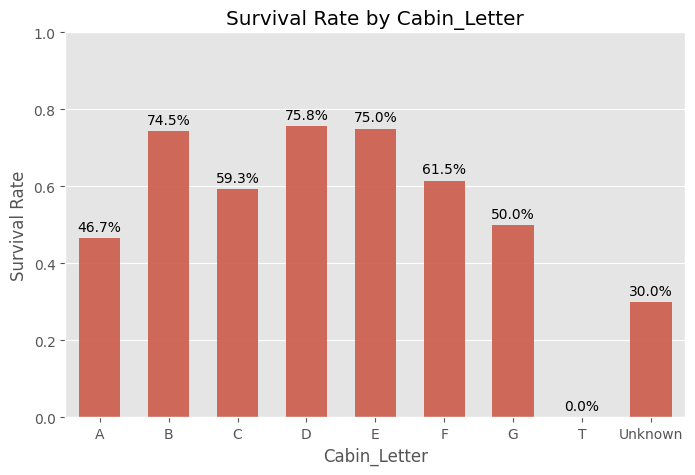

In [44]:
fig= plt.figure(figsize=(8,5))

Cabin_Letter_survival_rate = train.groupby('Cabin_Letter')['Survived'].mean().reset_index()
ax= sns.barplot(x='Cabin_Letter', y='Survived', data=Cabin_Letter_survival_rate,  alpha= 0.9, width= 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')
plt.title('Survival Rate by Cabin_Letter', )
plt.xlabel('Cabin_Letter')
plt.ylabel('Survival Rate')
plt.ylim([0, 1])

plt.show()

In [45]:
#Is_Female

train['Is_Female']= train.Sex.apply(lambda x: 1 if x=='female' else 0)


In [46]:
#Family_size

train['Family_Size']= train['Parch'] + train['SibSp'] + 1


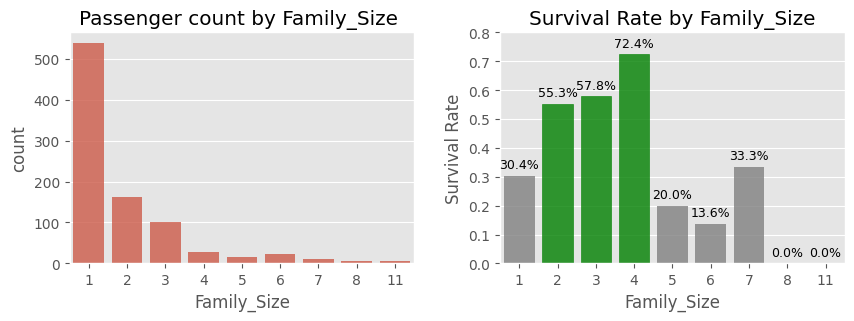

In [47]:
fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Family_Size", data=train, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by Family_Size ")

ax2= plt.subplot(1,2,2)
Family_Size_survival_rate = train.groupby('Family_Size')['Survived'].mean().reset_index().sort_values(by='Survived', ascending=False)
sns.barplot(x='Family_Size', y='Survived', data=Family_Size_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,4):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by Family_Size')
ax2.set_xlabel('Family_Size')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.8])

for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

In [48]:
train['Family_Size']=train['Family_Size'].map({1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'})

In [49]:
# Group size

tickets= all_data.groupby(['Ticket'])[['PassengerId']].count().rename(columns={'PassengerId': 'Count'})
tickets.head()

,Count
Ticket,
110152,3
110413,3
110465,2
110469,1
110489,1


In [50]:
train['Group_Size']=train['Ticket'].apply(lambda x: tickets.loc[x, 'Count'])


In [51]:
#Title

train['Title'] = train['Name'].str.split(', ').str[1].str.split('.').str[0]


In [52]:
all_data['Title'] = all_data['Name'].str.split(', ').str[1].str.split('.').str[0]
all_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [53]:
title_mapping= {'Mr':'Mr', 'Mrs':'Mrs', 'Miss':'Miss','Master':'Master', 'Don':'Rare', 'Rev':'Rare', 'Dr':'Rare', 'Mme':'Mrs', 'Ms':'Miss',
       'Major':'Rare', 'Lady':'Rare' , 'Sir':'Rare', 'Mlle':'Miss', 'Col':'Rare', 'Capt':'Rare', 'the Countess':'Rare',
       'Jonkheer':'Rare', 'Dona':'Rare'}
train['Title']= train['Title'].map(title_mapping)

In [54]:
train['Title'].value_counts()


Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

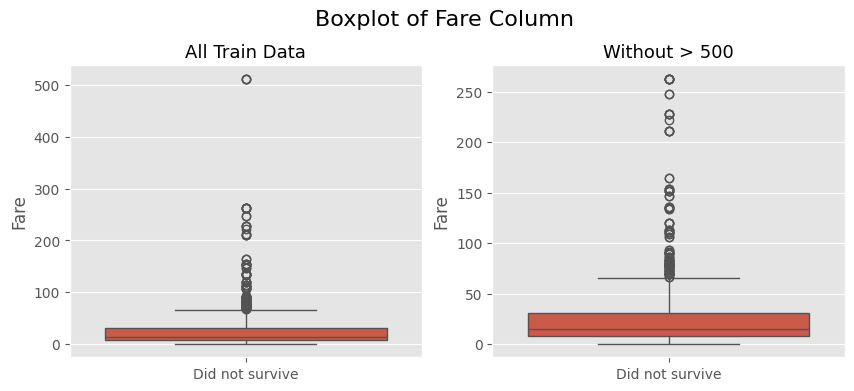

In [55]:
#Fare_bin

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
sns.boxplot(data=train, y="Fare", ax=ax1)
ax1.set_xticks([0], ['Did not survive'])
ax1.set_title("All Train Data", fontsize= 13)

ax2 = plt.subplot(1, 2, 2)
sns.boxplot(data=train[train['Fare']<500], y="Fare",  ax=ax2)
ax2.set_xticks([0], ['Did not survive'])
ax2.set_title("Without > 500", fontsize= 13)

plt.suptitle('Boxplot of Fare Column', fontsize= 16)
plt.subplots_adjust(top=0.84)

plt.show()

In [56]:
Q1, Q2, Q3 = np.percentile(train['Fare'], [25, 50, 75])
IQR = Q3 - Q1

fare_bin_edges = [-np.inf, Q1, Q2, Q3, 1.5 * IQR, np.inf]

fare_bin_labels=[]
for i in range(len(fare_bin_edges)-1):
    fare_bin_labels.append("{}_to_{}".format(fare_bin_edges[i], fare_bin_edges[i+1]))

train['Fare_bin'] = pd.cut(train['Fare'], bins=fare_bin_edges, labels=fare_bin_labels)

In [57]:
print(Q1 - 1.5 * IQR)


-26.724


In [58]:
train[['Fare_bin']].value_counts()


Fare_bin         
7.9104_to_14.4542    224
-inf_to_7.9104       223
14.4542_to_31.0      222
34.6344_to_inf       200
31.0_to_34.6344       22
Name: count, dtype: int64

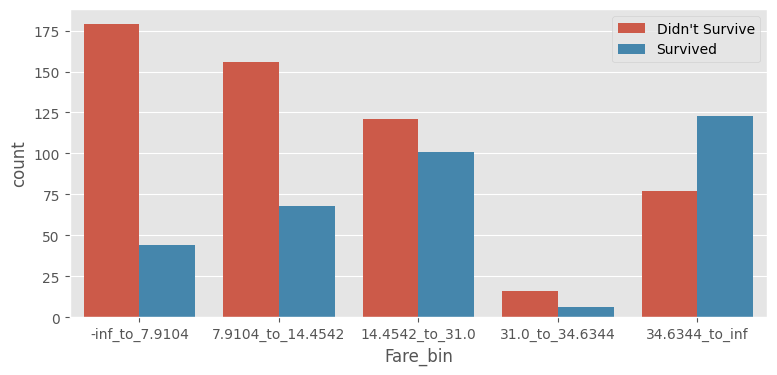

In [59]:
plt.figure(figsize=(9,4))
sns.countplot(x='Fare_bin', hue='Survived', data=train)
plt.legend(labels=["Didn't Survive","Survived"])
plt.show()

In [60]:
#Age_bin

Q1 = train['Age'].quantile(0.25)
Q3 = train['Age'].quantile(0.75)
IQR = Q3 - Q1

num_bins = 10
age_bin_edges = np.linspace(start=0, stop=train.Age.max(), num=num_bins + 1).astype(int)

age_bin_labels=[]
for i in range(len(age_bin_edges)-1):
    age_bin_labels.append("{}_to_{}".format(age_bin_edges[i], age_bin_edges[i+1]))

train['Age_bin'] = pd.cut(train['Age'], bins=age_bin_edges, labels= age_bin_labels)

In [61]:
train['Age_bin'].value_counts()


Age_bin
24_to_32    274
16_to_24    219
32_to_40    148
40_to_48     70
0_to_8       54
8_to_16      46
48_to_56     45
56_to_64     24
64_to_72      9
72_to_80      2
Name: count, dtype: int64

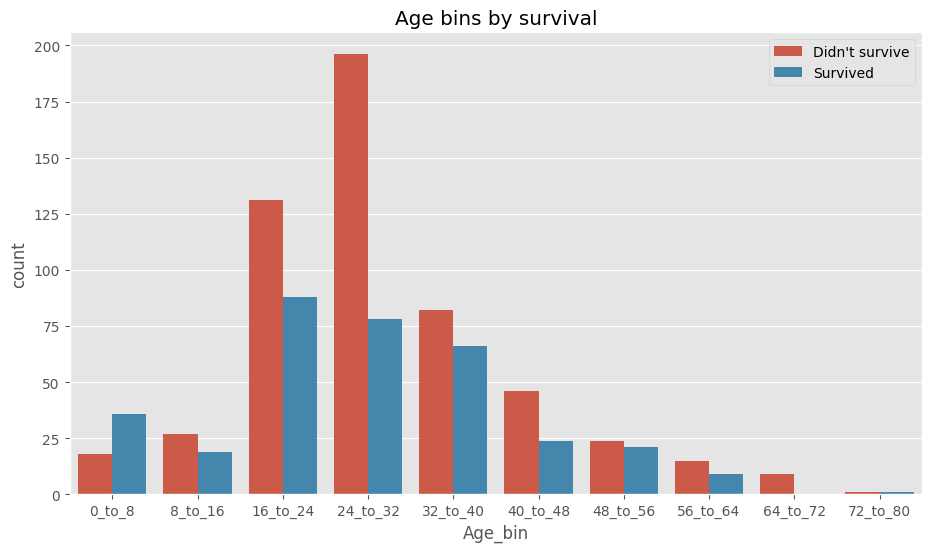

In [62]:
plt.figure(figsize=(11,6))
sns.countplot(x='Age_bin', hue='Survived', data=train)
plt.legend(["Didn't survive","Survived"])
plt.title('Age bins by survival')
plt.show()

## Feature Interaction

In [63]:
train["Age_bin_Sex"] = train["Age_bin"].astype(str) + "_" + train["Sex"]
train["Age_bin_Pclass"] = train["Age_bin"].astype(str) + "_" + train["Pclass"].astype(str)

train["Fare_bin_Sex"] = train["Fare_bin"].astype(str) + "_" + train["Sex"]
train["Fare_bin_Pclass"] = train["Fare_bin"].astype(str) + "_" + train["Pclass"].astype(str)

train["Pclass_Sex"] = train["Pclass"].astype(str) + "_" + train["Sex"]
train["Pclass_Title"] = train["Pclass"].astype(str) + "_" + train["Title"]
train["Sex_Title"] = train["Sex"].astype(str) + "_" + train["Title"]

train["Age_bin_Title"] = train["Age_bin"].astype(str) + "_" + train["Title"]
train["Fare_bin_Title"] = train["Fare_bin"].astype(str) + "_" + train["Title"]

train['Fam_Size_Cabin']= train["Family_Size"].astype(str) + "_" + train["Cabin_Letter"].astype(str)
train['Fam_Size_Parch']= train["Family_Size"].astype(str) + "_" + train["Parch"].astype(str)
train['Fam_Size_Fare_bin']= train["Family_Size"].astype(str) + "_" + train["Fare_bin"].astype(str)

train['SibSp_Parch_Ratio'] = train.apply(lambda x: x['SibSp'] / train.loc[x.name, 'Parch'] if train.loc[x.name, 'Parch'] != 0 else 0, axis=1)
train['Age_bin_Fare_bin']= train["Age_bin"].astype(str) + "_" + train["Fare_bin"].astype(str)

TypeError: can only concatenate str (not "int") to str